#### Architecture - Semantic Search using Elastic Search


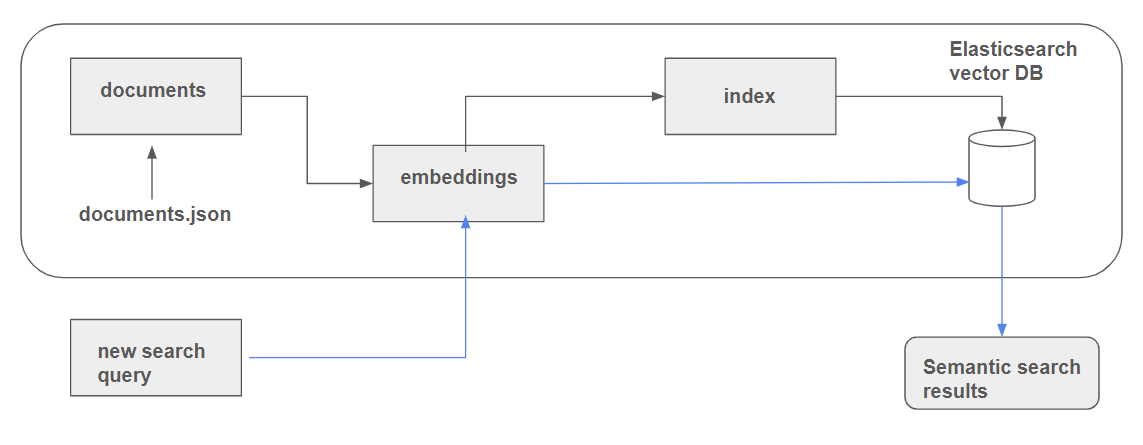

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [1]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [2]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [2]:
from sentence_transformers import SentenceTransformer

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [5]:
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

In [6]:
user_question = "I just discovered the course. Can I still join it?"

In [7]:
model.encode(user_question)

array([ 7.82226548e-02, -4.01311405e-02,  3.86135913e-02, -1.78966438e-04,
        8.92347097e-02, -5.04591092e-02, -1.05026569e-02,  3.71055678e-02,
       -4.18713912e-02,  3.48084792e-02, -1.20701883e-02, -2.36942340e-02,
        3.87900174e-02,  1.60988607e-02,  3.50747295e-02,  3.04746162e-03,
        5.79672381e-02, -4.10627462e-02, -3.41552682e-02, -2.56396383e-02,
       -3.55263911e-02,  1.42908087e-02, -1.62799917e-02,  3.21446545e-02,
       -4.66897376e-02,  7.89186060e-02,  4.90160920e-02,  1.56761166e-02,
       -1.69110075e-02,  2.26482227e-02,  5.60206100e-02, -3.98361087e-02,
        6.77409917e-02, -1.20209912e-02,  1.12621894e-03, -1.94394365e-02,
       -2.65951678e-02,  1.06177367e-02,  1.69687122e-02,  1.13487840e-02,
       -2.97063086e-02,  5.25258258e-02, -1.41453547e-02,  4.61699851e-02,
        1.17066065e-02, -2.38053519e-02, -6.32558241e-02, -1.92042235e-02,
       -7.10592186e-03,  3.24167833e-02,  2.49618199e-02, -5.27503015e-03,
        2.01149024e-02, -

In [ ]:
#created the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

#### Step 3: Setup ElasticSearch connection 

In [ ]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [ ]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [ ]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

#### Step 5: Add documents into index

In [ ]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [ ]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [ ]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [ ]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [ ]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [ ]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

In [ ]:
response["hits"]["hits"]

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch